In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from scipy import sparse
%matplotlib inline

Load the new dataset we had created in the first notebook

In [2]:
data = pd.read_csv('datasets/dataset2.csv')
data.head()

,Unnamed: 0,user_id,number_of_ticks,date_created,chapter,book,numberofentriesofbook,numberofusersofbook,product_manning_id,user_owns_book,source,target,next_user,keep_edge
0,1,-2146355313,8,"""2019-12-14 10:05:50""",chapter-8,fain3,737,225,1069,1,"fain3, chapter-8","ramamurthy, chapter-1",-2.146355e+09,1.0
1,2,-2146355313,8,"""2019-12-14 10:05:50""",chapter-1,ramamurthy,715,202,1120,1,"ramamurthy, chapter-1","thomas, chapter-1",-2.146355e+09,1.0
2,29,-2145886989,10,"""2019-12-10 13:07:05""",chapter-4,mcnamara,2533,461,880,1,"mcnamara, chapter-4","mcnamara, chapter-4",-2.145887e+09,1.0
3,32,-2145886989,10,"""2019-12-10 13:41:25""",chapter-4,mcnamara,2533,461,880,1,"mcnamara, chapter-4","mcnamara, chapter-1",-2.145887e+09,1.0
4,7,-2145886989,1,"""2019-12-10 19:37:20""",chapter-1,mcnamara,2533,461,880,1,"mcnamara, chapter-1","mcnamara, chapter-1",-2.145887e+09,1.0


Create NetworkX graph from it, draw the graph to confirm it worked

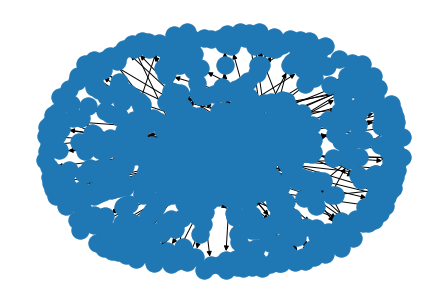

In [3]:
Graph1 = nx.from_pandas_edgelist(data, "source", "target", create_using=nx.DiGraph)
nx.draw(Graph1)

Calculate the centrality measures (out degree centrality, betweenness centrality, and eigenvector centrality) for every node. Each node is a book chapter.

In [4]:
centrality_measure_functions = [nx.betweenness_centrality, nx.eigenvector_centrality, nx.eigenvector_centrality]
centrality_measure_labels = ['out-degree', 'betweenness', 'eigen']

for cm_function, cm_label in zip(centrality_measure_functions, centrality_measure_labels):
    nx.set_node_attributes(Graph1, cm_function(Graph1), cm_label)

To make a dataframe of the centrality measures for every book chapter, first need to turn the graph into a list of tuples. Each tuple has two components: The chapter of the book and a dictionary with the values of each centrality measure

In [5]:
node_list=list(Graph1.nodes(data=True))
node_list

[('fain3, chapter-8',
  {'out-degree': 0.0,
   'betweenness': 5.159156970479536e-46,
   'eigen': 5.159156970479536e-46}),
 ('ramamurthy, chapter-1',
  {'out-degree': 5.091126065445408e-07,
   'betweenness': 3.4050436005164946e-44,
   'eigen': 3.4050436005164946e-44}),
 ('thomas, chapter-1',
  {'out-degree': 0.0,
   'betweenness': 1.1071550858649084e-42,
   'eigen': 1.1071550858649084e-42}),
 ('mcnamara, chapter-4',
  {'out-degree': 0.0010951012166773072,
   'betweenness': 7.421038983061692e-11,
   'eigen': 7.421038983061692e-11}),
 ('mcnamara, chapter-1',
  {'out-degree': 0.0015405747474037806,
   'betweenness': 5.1056640257968935e-11,
   'eigen': 5.1056640257968935e-11}),
 ('mcnamara, chapter-2',
  {'out-degree': 0.002719170431554393,
   'betweenness': 8.256859417671816e-11,
   'eigen': 8.256859417671816e-11}),
 ('hillard, chapter-9',
  {'out-degree': 0.0,
   'betweenness': 3.365361593998789e-11,
   'eigen': 3.365361593998789e-11}),
 ('vos, chapter-2',
  {'out-degree': 0.0119768740689

Turn the list of tuples into a dictionary that will be used to make the dataframe

In [6]:
bookchapter_centrality_measures_dict = {'bookchapter': [], 'out_degree':[], 'betweenness':[], 'eigen':[]}
for bookchapter, centrality_measures in node_list:
    bookchapter_centrality_measures_dict['bookchapter'].append(bookchapter)
    bookchapter_centrality_measures_dict['out_degree'].append(centrality_measures['out-degree'])
    bookchapter_centrality_measures_dict['betweenness'].append(centrality_measures['betweenness'])
    bookchapter_centrality_measures_dict['eigen'].append(centrality_measures['eigen'])
    
bookchapter_centrality_measures_df = pd.DataFrame(bookchapter_centrality_measures_dict)
bookchapter_centrality_measures_df.set_index('bookchapter', inplace=True)
bookchapter_centrality_measures_df.head(10)

,out_degree,betweenness,eigen
bookchapter,,,
"fain3, chapter-8",0.000000e+00,5.159157e-46,5.159157e-46
"ramamurthy, chapter-1",5.091126e-07,3.405044e-44,3.405044e-44
"thomas, chapter-1",0.000000e+00,1.107155e-42,1.107155e-42
"mcnamara, chapter-4",1.095101e-03,7.421039e-11,7.421039e-11
"mcnamara, chapter-1",1.540575e-03,5.105664e-11,5.105664e-11
"mcnamara, chapter-2",2.719170e-03,8.256859e-11,8.256859e-11
"hillard, chapter-9",0.000000e+00,3.365362e-11,3.365362e-11
"vos, chapter-2",1.197687e-02,3.530180e-11,3.530180e-11
"mcnamara, chapter-3",9.724051e-05,5.680737e-11,5.680737e-11


Create a function that returns the book chapters linked to a given chapter of a book, organized by a specified centrality measure. The default centrality measure is the eigenvector centrality

In [7]:
def produce_recommendation(bookchapter: str, centrality_measure: str='eigen') -> pd.DataFrame:
    recommendation=bookchapter_centrality_measures_df.loc[[n for n in Graph1[bookchapter]]]
    recommendation.sort_values(by=[centrality_measure],ascending=False, inplace=True)
    return recommendation

In [8]:
produce_recommendation('mcnamara, chapter-5')

,out_degree,betweenness,eigen
bookchapter,,,
"mcnamara, chapter-4",0.001095,7.421039e-11,7.421039e-11
"mcnamara, chapter-5",0.000006,5.105664e-11,5.105664e-11
"mcnamara, chapter-6",0.000000,3.512960e-11,3.512960e-11


In [9]:
produce_recommendation(bookchapter='mcnamara, chapter-4', centrality_measure='out_degree')

,out_degree,betweenness,eigen
bookchapter,,,
"mcnamara, chapter-1",0.001541,5.105664e-11,5.105664e-11
"mcnamara, chapter-4",0.001095,7.421039e-11,7.421039e-11
"mcnamara, chapter-5",0.000006,5.105664e-11,5.105664e-11


Save the book_chapter_centrality_measures_df and Graph1 variables so they can be used in the next assignment

In [10]:
bookchapter_centrality_measures_df.to_csv('datasets/bookchapter_centrality_measures_df.csv')
nx.readwrite.gexf.write_gexf(Graph1, 'datasets/bookchapters_graph.gexf', encoding='utf-8')